# GradCAM example for 3 models

In [10]:
from pathlib import Path

current_dir = Path.cwd()  # this points to 'notebooks/' folder
proj_path = current_dir.parent.parent 
print(proj_path)

C:\Users\wenceslas\Documents\cours\ENSAE\2A\Normal\statapp\nlp_understanding


In [106]:
import pandas as pd
import numpy as np
import itertools
import torch
from torch.utils.data import DataLoader
import pickle

from deep_nlp.cnncharclassifier import CNNCharClassifier, charToTensor
from src.deep_nlp.embed_cnn.embcnnmodel_gradcam import classifier3F
from deep_nlp.bilstm_cnn.bilstmcnn_gradcam import BilstmCnn
from deep_nlp.grad_cam.utils.letter import rebuild_text, prepare_heatmap, LetterToToken
from deep_nlp.grad_cam.plot import plot_bar_heatmap, plot_text_and_heatmap

## CNN Character level

In [12]:
# params
cnn_sequence_len= 1014
cnn_feature_num= 87
cnn_feature_size= 256
cnn_kernel_one= 7
cnn_kernel_two= 3
cnn_stride_one= 1
cnn_stride_two= 3
cnn_output_linear= 1024
cnn_num_class= 2
cnn_dropout= 0.5
cnn_cuda_allow= True

In [13]:
# Load model
model_path_saved= "data/06_models/cnn_char_classifier/cnn_char_model/cnn_char_model.pt"

with open(str(proj_path)+ "\\" + model_path_saved, 'rb') as f:
    model_saved= pickle.load(f)

In [14]:
# Load test data
data_df= pd.read_csv(str(proj_path)+ "\\" + "data/01_raw/allocine_test.csv")

test_data= charToTensor(data_df= data_df, sentence_max_size= cnn_sequence_len)

In [15]:
# Initialisation
parameters = {"sequence_len": cnn_sequence_len, "feature_num": cnn_feature_num
    , "feature_size": cnn_feature_size, "kernel_one": cnn_kernel_one
    , "kernel_two": cnn_kernel_two, "stride_one": cnn_stride_one
    , "stride_two": cnn_stride_two, "output_linear": cnn_output_linear
    , "num_class": cnn_num_class, "dropout": cnn_dropout}

In [16]:
model = CNNCharClassifier(**parameters)

if cnn_cuda_allow:
    model = torch.nn.DataParallel(model).cuda()
else:
    model = torch.nn.DataParallel(model)

model.load_state_dict(model_saved)

state_dict= model.module.state_dict() # delete module to allow cpu loading

cpu_model= CNNCharClassifier(**parameters).cpu()
cpu_model.load_state_dict(state_dict)

cpu_model.eval()

CNNCharClassifier(
  (before_conv): Sequential(
    (conv1_conv): Conv1d(87, 256, kernel_size=(7,), stride=(1,))
    (conv1_relu): ReLU()
  )
  (pool): Sequential(
    (conv1_maxpool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (after_conv): Sequential(
    (conv2): Sequential(
      (0): Conv1d(256, 256, kernel_size=(7,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (conv4): Sequential(
      (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (conv5): Sequential(
      (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (conv6): Sequential(
      (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  

In [52]:
# Display results
def cnn_char_gradcam(index, threshold= None,**kwargs):
    """
    Display gradcam text with knowing the index text position
    
    -------
    
    kwargs:
        - model
        - loader : type charToTensor
        - cnn_sequence_len
        - params_graphics
    """
    loader= kwargs["loader"]
    model= kwargs["model"]
    type_map= kwargs["type_map"]
    num_class= kwargs["num_class"] 
    figsize= kwargs["figsize"]
    
    text_sentence, _= loader[index]
    text_sentence= torch.unsqueeze(text_sentence, 0)
    
    model.eval()
    output= model(text_sentence)
    print("Proba class 1 : {}".format(torch.exp(output)[:, 1].data.numpy()[0]))
    
    heatmap_= model.get_heatmap(text= text_sentence
                                    , num_class= num_class
                                    , dim= [0, 2]
                                    , type_map= type_map)
    
    # get the unique element
    heatmap_values= heatmap_[-1]
    
    # CNNChar rebuilt from input the text
    alphabet= loader.get_alphabet()+" "
    rebuild_sentence= rebuild_text(text= text_sentence
                                     , alphabet= alphabet
                                     , space_index= len(alphabet) - 1 #83 # ajout de +4 si pas fait
                                     , sequence_len= cnn_sequence_len)
    
    # Resize heatmap Brutal method
    heatmap_match_sentence_size_invert= prepare_heatmap(heatmap= heatmap_values
                                                    , text= rebuild_sentence)
    
    ## Transform character level to token one
    letter_to_token= LetterToToken(text= rebuild_sentence
                                   , heatmap= heatmap_match_sentence_size_invert)

    results_dict= letter_to_token.transform_letter_to_token(type= "tanh")
    tokens= results_dict["tokens"]
    heatmap_test= results_dict["heatmap"]
    
    if threshold: # if inquired
        condition= np.where(heatmap_test < threshold)[0] # if under, get index
        heatmap_test[condition]= 0 # replace undervalues by 0
    
    plot_text_and_heatmap(text= tokens
                      , heatmap= heatmap_test
                      , figsize= figsize
                      , fontsize_text= "small"
                      , cmap= "Greens" if type_map == "max" else "PiYG"
                      , word_or_letter= "word")
    pass

Proba class 1 : 0.9985169768333435


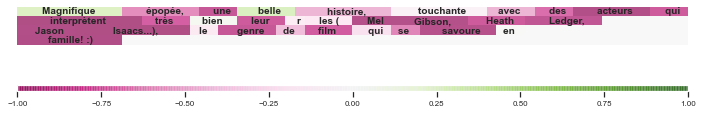

Proba class 1 : 0.9985169768333435


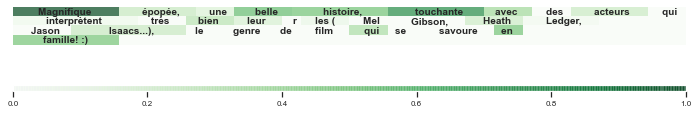

In [123]:
# %matplotlib
index= 0
num_class= 1
figsize= (10, 4)
cnn_char_gradcam(index, model= cpu_model, loader= test_data, type_map= "normalized"
                 , num_class= num_class, figsize= figsize)
cnn_char_gradcam(index, model= cpu_model, loader= test_data, type_map= "max"
                 , num_class= num_class, figsize= figsize)

## Embedding vanilla

In [54]:
test_iterator_cnn_embed_path= "data/02_intermediate/test_iterator_cnn_embed.pkl"

with open(str(proj_path)+ "\\" + test_iterator_cnn_embed_path, 'rb') as f:
    test_iterator_cnn_embed= pickle.load(f)
    
print(type(test_iterator_cnn_embed))

<class 'torch.utils.data.dataloader.DataLoader'>


In [55]:
# Embedding model
embed_for_torch_path= "data/04_feature/w2v_torch.pkl"

with open(str(proj_path)+ "\\" + embed_for_torch_path, 'rb') as f:
    embed_for_torch= pickle.load(f)
    
print(type(embed_for_torch))

<class 'torch.Tensor'>


In [56]:
word_ind_dict_path= "data/04_feature/voc.pkl"

with open(str(proj_path)+ "\\" + word_ind_dict_path, 'rb') as f:
    word_ind_dict= pickle.load(f)
    
print(type(word_ind_dict))

<class 'dict'>


In [57]:
# Params
params_models = {"wv": embed_for_torch,"no_words": 67,"embedding_dim":200, "nb_filter":200
                 , "height_filter":tuple([1, 2, 3, 4, 5]), "output_dim":2, "dropout":0.8, "padded":True}

In [58]:
# Model dict
embed_cnn_model_for_save_path= "data/06_models/embed_cnn/embed_cnn_classifier/embed_cnn.pt"

with open(str(proj_path)+ "\\" + embed_cnn_model_for_save_path, 'rb') as f:
    embed_cnn_model_for_save= pickle.load(f)
    
print(type(embed_cnn_model_for_save))

<class 'collections.OrderedDict'>


In [63]:
model_embed = classifier3F(**params_models)

model_embed.load_state_dict(embed_cnn_model_for_save)
model_embed= model_embed.cpu()
model_embed.eval()

classifier3F(
  (before_conv): Sequential(
    (conv1_conv_1): Conv2d(1, 200, kernel_size=(1, 200), stride=(1, 1))
    (conv1_conv_2): Conv2d(1, 200, kernel_size=(2, 200), stride=(1, 1))
    (conv1_conv_3): Conv2d(1, 200, kernel_size=(3, 200), stride=(1, 1))
    (conv1_conv_4): Conv2d(1, 200, kernel_size=(4, 200), stride=(1, 1))
    (conv1_conv_5): Conv2d(1, 200, kernel_size=(5, 200), stride=(1, 1))
    (conv1_relu): ReLU()
  )
  (pool): Sequential(
    (conv1_maxpool): Sequential(
      (0): MaxPool1d(kernel_size=67, stride=1, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (after_conv): Sequential(
    (dp): Dropout(p=0.8, inplace=False)
    (fc): Linear(in_features=1000, out_features=2, bias=True)
    (sm): Softmax(dim=1)
  )
  (embedding): Embedding(155564, 200)
  (conv1_conv): ModuleList(
    (0): Conv2d(1, 200, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 200, kernel_size=(2, 200), stride=(1, 1))
    (2): Conv2d(1, 200, kernel_size=(3, 200), stride=(1, 1))
    (3):

In [137]:
# display
def embed_gradcam(index, heatmap_index, index_nothing= None, model_type= None
                  , threshold= None,**kwargs):
    """
    Display gradcam text with knowing the index text position
    
    -------
    
    kwargs:
        - model
        - loader : type charToTensor
        - cnn_sequence_len
        - params_graphics
    """
    data_loader= kwargs["data_loader"]
    model= kwargs["model"]
    type_map= kwargs["type_map"]
    num_class= kwargs["num_class"] 
    figsize= kwargs["figsize"]
    vocab= kwargs["vocab"]
    
    text_sentence, _= next(itertools.islice(data_loader, index, None))
    if model_type == "bilstm":
        text_sentence= text_sentence.to(torch.int64)
    
    model.eval()
    output= model(text_sentence)
    print("Proba class 1 : {}".format(output[:, 1].data.numpy()[0]))
    
    heatmap_= model.get_heatmap(text= text_sentence
                                    , num_class= num_class
                                    , dim= [0, 2]
                                    , type_map= type_map)
    heatmap_values= heatmap_[heatmap_index]
    
    text_index = text_sentence.squeeze().numpy()
    vocab_reverse= {y:x for x,y in vocab.items()}
    word = np.array([vocab_reverse.get(index, "") for index in text_index])
    
    if index_nothing is None: # generate warning but its ok dude
        index_nothing = np.array([])
    selected_word_bool = np.in1d(text_index, index_nothing)
    # Get index of word we want
    selected_word_index = np.where(~selected_word_bool)[0]

    # Select interesting words
    selected_word = word[selected_word_index]
    selected_heatmap_values= heatmap_values[selected_word_index]
    
    if threshold: # if inquired
        condition= np.where(selected_heatmap_values < threshold)[0] # if under, get index
        selected_heatmap_values[condition]= 0 # replace undervalues by 0
    
    plot_text_and_heatmap(text= selected_word.tolist()
                      , heatmap= selected_heatmap_values
                      , figsize= figsize
                      , fontsize_text= "small"
                      , cmap= "Greens" if type_map == "max" else "PiYG"
                      , word_or_letter= "word")
    
    pass

Proba class 1 : 0.04856044426560402


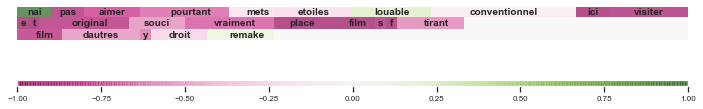

In [122]:
index= 1
num_class= 1
figsize= (10, 4)
index_nothing= np.array([155563, 155562])

embed_gradcam(index, heatmap_index= -1, model= model_embed, data_loader= test_iterator_cnn_embed
                , type_map= "normalized", vocab= word_ind_dict, num_class= num_class, figsize= figsize
                , index_nothing= index_nothing)

## Bilstm

In [114]:
#
embed_matrix_path= "data/02_intermediate/bilstm_cnn/embed_matrix.pkl"

with open(str(proj_path)+ "\\" + embed_matrix_path, 'rb') as f:
    embed_matrix= pickle.load(f)
    
print(type(embed_matrix))

<class 'numpy.ndarray'>


In [115]:
word_ind_dict_path_bilstm= "data/04_feature/voc_bilstm.pkl"

with open(str(proj_path)+ "\\" + word_ind_dict_path_bilstm, 'rb') as f:
    word_ind_dict_bilstm= pickle.load(f)
    
print(type(word_ind_dict_bilstm))

<class 'dict'>


In [116]:
#
test_batch_bilstm_path= "data/02_intermediate/test_iterator_cnn_bilstm.pkl"

with open(str(proj_path)+ "\\" + test_batch_bilstm_path, 'rb') as f:
    test_batch_bilstm= pickle.load(f)
    
print(type(test_batch_bilstm))#BiLSTM + CNN
num_epochs=  50
batch_size= 32
patience= 5
lr= 0.001
input_dim= 200
hidden_dim= 128
layer_dim= 2
feature_size= 256
output_dim= 2
kernel_size= 3
dropout_rate= 0.5
sentence_size= 67
padded= True

<class 'torch.utils.data.dataloader.DataLoader'>


In [117]:
#
bilstm_cnn_model_for_save_path= "data/06_models/bilstm_cnn/bilstm_cnn_classifier/bilstm_cnn.pt"

with open(str(proj_path)+ "\\" + bilstm_cnn_model_for_save_path, 'rb') as f:
    bilstm_cnn_model_for_save= pickle.load(f)
    
print(type(bilstm_cnn_model_for_save))

<class 'collections.OrderedDict'>


In [118]:
model = BilstmCnn(embed_matrix, sentence_size, input_dim, hidden_dim
                  , layer_dim, output_dim, feature_size, kernel_size, dropout_rate, padded)

if cnn_cuda_allow:
    model = torch.nn.DataParallel(model).cuda()
else:
    model = torch.nn.DataParallel(model)

model.load_state_dict(bilstm_cnn_model_for_save)

state_dict= model.module.state_dict() 

cpu_bilstm_model= BilstmCnn(embed_matrix, sentence_size, input_dim, hidden_dim
                  , layer_dim, output_dim, feature_size, kernel_size, dropout_rate, padded).cpu()

cpu_bilstm_model.load_state_dict(state_dict)
cpu_bilstm_model

BilstmCnn(
  (before_conv): Sequential(
    (conv): Sequential(
      (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (pool): Sequential(
    (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (after_conv): Sequential(
    (fc): Linear(in_features=8448, out_features=2, bias=True)
    (sm): Softmax(dim=1)
  )
  (embedding): Embedding(144214, 200, padding_idx=0)
  (LSTM): LSTM(200, 128, num_layers=2, dropout=0.5, bidirectional=True)
  (convLayer): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=8448, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

Proba class 1 : 0.48707589507102966


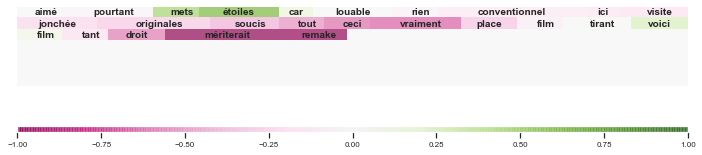

In [138]:
index= 1
num_class= 1
figsize= (10, 4)
index_nothing= np.array([144213])

embed_gradcam(index, heatmap_index= -1, model_type= "bilstm", model= cpu_bilstm_model, data_loader= test_batch_bilstm
                , type_map= "normalized", vocab= word_ind_dict_bilstm, num_class= num_class, figsize= figsize
                , index_nothing= index_nothing)